# QQQ / SCHD 정적 자산분배 포트폴리오 수익률 분석 백테스팅

### 동기 : 유튜브 영상 중 QQQ와 SCHD ETF의 비중을 조절하여 분할매수 후 장기투자 시, 연 4%의(물가상승률 고려) 고정수익 창출이 가능할 것이라는 분석영상 시청 후 실효성 확인을 위해 장기간 투자 시 누적수익률을 확인하고자 한다.

> https://www.youtube.com/watch?v=wVQ4S5oHrgE

- SCHD(ETF) : 다우존스 Dividend 100 INDEX를 기초자산으로 추종(배당금 지급 미국 주식 100개의 시총 지수 추종)

- QQQ(ETF) : 나스닥 상장주 중 금융주 제외 상위 100종목을 추종

- CAGR 및 MDD : 연평균 성장률 / 최대 낙폭


### 2011/11 ~ 2024/06 QQQ + SCHD 분할매수 백테스팅

- 투자 비율별 수익률 분석 (8:2 ~ 2:8)


> Reference : https://dotsnlines.tistory.com/1105

### 조건
1. QQQ와 SCHD를 매월 5:5 비율로 리밸런싱을 수행한다.
2. 초기투입투자금은 2,000달러이며 매월 1,000달러씩 추가금을 투입한다.
3. 배당수익은 재투자를 가정한다.
4. 매매수수료 0.25%, 배당소득세 15.4%를 반영한다.
5. 기간은 QQQ와 SCHD 중 상장일이 더 늦은 자산을 기준으로(데이터 로딩 이슈) 2024/6/27(6월 마지막 영업일) 까지로 설정됐다.

In [ ]:
import pandas as pd
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from pandas_datareader import data as pdr
from datetime import datetime
pd.options.display.float_format = '{:,.2f}'.format

p1 = 'QQQ' ; p2 = 'SCHD'

p1비율 = 0.5

# Preliminary : QQQ와 SCHD의 상관관계 분석

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
<ipython-input-147-89d1430ef7d7>:10: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method = 'bfill')
<ipython-input-147-89d1430ef7d7>:11: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method = 'ffill')


Text(0, 0.5, 'QQQ')

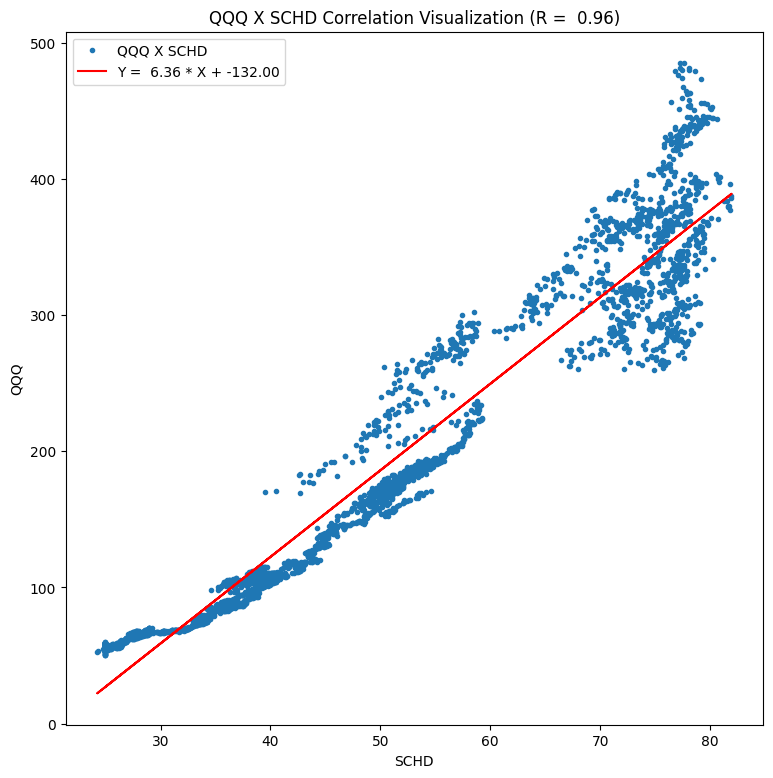

In [ ]:
start = datetime(2011, 1, 1) # 상장일 때문에 2011년 10월 후반기로 잘림
end = datetime(2024, 6, 28) # 6월 마지막 영업일

df1 = yf.download(p1, start, end) # QQQ 주가
df2 = yf.download(p2, start, end) # SCHD 주가

df = pd.DataFrame({'X' : df2['Close'], 'Y' : df1['Close']})

# 결측치 채워넣기
df = df.fillna(method = 'bfill')
df = df.fillna(method = 'ffill')

# 회귀분석 모듈 이용
regr = stats.linregress(df.X, df.Y)
regr_line = f'Y = {regr.slope : .2f} * X + {regr.intercept : .2f}'

# 상관관계 나타내기
plt.figure(figsize = (9, 9))
plt.plot(df.X, df.Y, '.') # 주가를 점으로 표시함
plt.plot(df.X, regr.slope * df.X + regr.intercept, 'r') # X : SCHD, Y : QQQ

plt.legend(["QQQ X SCHD", regr_line])

plt.title(f'QQQ X SCHD Correlation Visualization (R = {regr.rvalue : .2f})')
plt.xlabel("SCHD")
plt.ylabel("QQQ")

### 결과
---

- R = 0.96으로 매우 높은 상관관계를 나타낸다.

- QQQ는 주로 기술주 중심의 ETF, SCHD는 배당주 중심의 ETF임. 두 ETF 간 높은 상관관계는 기술주와 배당주 모두 장기적으로 유사한 상승추세를 보였음을 암시한다.

- 포트폴리오 이론에 따르면 두 자산은 높은 양의 상관관계를 나타내므로 분산투자 효과를 누리지는 못하는 것으로 보인다.(개인해석, 오역 가능)

- 회귀방정식 Y(QQQ) = 6.36 * X(SCHD) + (-132.00) : SCHD 주가가 $1 증가 시 QQQ 주가가 평균적으로 $6.36 단위 증가함을 의미한다. QQQ의 주가 변동성이 SCHD의 주가 변동성보다 크다는 것을 시사함.
    - QQQ의 비율이 높을수록 CAGR은 높아지고 MDD가 낮아질 것이라고 예측해볼 수 있을 것이다.(개인해석, 오역 가능)

# 실제 분석 진행

### 배당금($) 구하기 + 메소드화

In [ ]:
def get_div(p):
    ticker = yf.Ticker(p)
    div = ticker.dividends.tz_localize(None)
    return div

### 초기 세팅

In [ ]:
매매수수료 = 0.0025 # (0.25%)
배당소득세 = 0.154 # (2천만원 미만 : 15.4% 세율 적용)
양도소득세 = 0.22 # (미국 주식이므로 손익통산 250만원 초과 시, 초과분에 대한 22% 세율 적용)
초기투자금 = 2000 # $
매월투자금 = 1000 # $
배당금적용여부 = 1 # 1(적용 : 배당수익 재투자 가정) / 0(미적용)

start = datetime(2011, 1, 1) # 상장일 때문에 2011년 10월 후반기로 잘림
end = datetime(2024, 6, 28) # 6월 마지막 영업일

### 데이터 로딩(pdr -> yf.download 대체)

In [ ]:
def get_data(p1, p2, start, end):
    df1 = yf.download(p1, start, end) # QQQ 주가
    df1.rename(columns = {'Adj Close' : 'p1주가'}, inplace = True)

    df2 = yf.download(p2, start, end) # SCHD 주가
    df2.rename(columns = {'Adj Close' : 'p2주가'}, inplace = True)

    df = pd.merge(df1['p1주가'], df2['p2주가'], left_index = True, right_index = True, how = 'inner')

    return df

### 배당금 적용 여부에 따라 배당금 데이터 concat

- 기 정의한 메소드들(get_data, get_div) 사용, 최종 데이터프레임 도출

In [ ]:
def merge_div(p1, p2, start, end):
    df = get_data(p1, p2, start, end)

    div1 = get_div(p1)
    div2 = get_div(p2)

    if 배당금적용여부 == 1:
        df['배당금1'] = div1
        df['배당금2'] = div2
        df.fillna(0, inplace = True) # NaN : 배당금 지급되지 않는 날짜임. "결측치 0"으로 채워야 함에 유의. 차후 결측 제거 수행 시 영향 가능성

    else:
        df['배당금1'] = 0
        df['배당금2'] = 0

    return df

### QQQ와 SCHD 데이터프레임 결합


In [ ]:
df = merge_div(p1, p2, start, end)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [ ]:
# df_m : 월말투자를 고려해서 li_monthlast 리스트로 매월 마지막 날을 추출하기 위한 임시 데이터프레임
df_m = df

df_m['date'] = df_m.index
df_m = df_m.groupby(by = [df.index.year, df.index.month]).last() # 매월 마지막날만 필터링
li_monthlast = df_m['date'].to_list() # 리스트화(매월 마지막날이 저장됨)

print(li_monthlast[0]) ; print(li_monthlast[len(li_monthlast) - 1]) # 월말 리스트 원소 확인

2011-10-31 00:00:00
2024-06-27 00:00:00


In [ ]:
df['투자금'] = 0 # 투자금 열 추가 생성 및 초기화

for i, m in enumerate(li_monthlast):
    if i == 0: # 초기 투자
        df['투자금'].loc[m] = 초기투자금 # 2,000 달러
    else:
        df['투자금'].loc[m] = 매월투자금 # 1,000 달러

### 적립식 투자 가정하고 자산변동 계산하기

In [ ]:
# 열 추가 생성 및 초기화
df[['p1주식수', 'p1금액', 'p2주식수', 'p2금액', '합계', '원금누계']] = 0


for m in range(len(df)):
    if m == 0: # 첫 iteration(2011/10/20, 추가한 열들 초깃값 init.)
        df['합계'].iloc[m] = df['투자금'].iloc[m] * (1 - 매매수수료) # 투자금(실제 매수 가정금액) '합계'는 매매수수료를 제한 금액

        df['p1금액'].iloc[m] = df['합계'].iloc[m] * p1비율
        df['p1주식수'].iloc[m] = df['p1금액'].iloc[m] / df['p1주가'].iloc[m]

        df['p2금액'].iloc[m] = df['합계'].iloc[m] - df['p1금액'].iloc[m]
        df['p2주식수'].iloc[m] = df['p2금액'].iloc[m] / df['p2주가'].iloc[m]

        df['원금누계'].iloc[m] = df['투자금'].iloc[m]

    # - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -

    else:
        df['합계'].iloc[m] = df['투자금'].iloc[m] * (1 - 매매수수료) + \
                            (df['p1주가'].iloc[m] * df['p1주식수'].iloc[m - 1]) + \
                            (df['p2주가'].iloc[m] * df['p2주식수'].iloc[m - 1]) + \
                            ((df['배당금1'].iloc[m] * df['p1주식수'].iloc[m - 1]) +
                            (df['배당금2'].iloc[m] * df['p2주식수'].iloc[m - 1])) * \
                            (1 - 배당소득세)

        if df['투자금'].iloc[m] > 0: # 매월 리밸런싱 할 때(매월 '말일')는 주식 수가 변한다.
            df['p1금액'].iloc[m] = df['합계'].iloc[m] * p1비율
            df['p1주식수'].iloc[m] = df['p1금액'].iloc[m] / df['p1주가'].iloc[m]

            df['p2금액'].iloc[m] = df['합계'].iloc[m] - df['p1금액'].iloc[m]
            df['p2주식수'].iloc[m] = df['p2금액'].iloc[m] / df['p2주가'].iloc[m]

        else: # 리밸런싱을 수행하지 않는 날에는 주식 수는 고정이다. 주식 수 먼저 구하고 금액을 산정해야 함에 유의한다.
            df['p1주식수'].iloc[m] = df['p1주식수'].iloc[m - 1] # 전일과 동일하므로.
            df['p1금액'].iloc[m] = df['p1주식수'].iloc[m] * df['p1주가'].iloc[m]

            df['p2주식수'].iloc[m] = df['p2주식수'].iloc[m - 1]
            df['p2금액'].iloc[m] = df['p2주식수'].iloc[m] * df['p2주가'].iloc[m]

        df['원금누계'].iloc[m] = df['원금누계'].iloc[m - 1] + df['투자금'].iloc[m]

In [ ]:
# 데이터프레임 가독성 향상을 위해 재배치

df = df[['p1주가', 'p1주식수', 'p1금액', '배당금1',
         'p2주가', 'p2주식수', 'p2금액', '배당금2',
         '투자금', '합계', '원금누계']]

### 두 가지 자산의 누적수익률 비교를 위해 백분율로 표현하기

In [ ]:
df['주가백분율1'] = df['p1주가'] / df['p1주가'].iloc[0] # iloc[0]은 2011년 10월 20일 주가 기준임에 유의
df['주가백분율2'] = df['p2주가'] / df['p2주가'].iloc[0] # iloc[0]은 2011년 10월 20일 주가 기준임에 유의
df['전략백분율'] = df['합계'] / df['원금누계']

df.dropna(inplace = True) # 2011-10-20 ~ 2011-10-30 데이터 +@ 삭제됨.

print(df)

             p1주가  p1주식수       p1금액  배당금1  p2주가    p2주식수       p2금액  배당금2  \
Date                                                                        
2011-10-31  51.52  19.36     997.50  0.00 17.20    58.00     997.50  0.00   
2011-11-01  50.18  19.36     971.51  0.00 16.81    58.00     974.81  0.00   
2011-11-02  50.61  19.36     979.77  0.00 17.03    58.00     987.72  0.00   
2011-11-03  51.66  19.36   1,000.08  0.00 17.30    58.00   1,003.37  0.00   
2011-11-04  51.39  19.36     994.92  0.00 17.23    58.00     999.06  0.00   
...           ...    ...        ...   ...   ...      ...        ...   ...   
2024-06-21 479.42 484.85 232,446.49  0.00 77.30 2,806.32 216,931.00  0.00   
2024-06-24 473.96 484.85 229,800.16  0.76 78.38 2,806.32 219,957.81  0.00   
2024-06-25 479.38 484.85 232,428.06  0.00 77.76 2,806.32 218,208.37  0.00   
2024-06-26 480.37 484.85 232,908.06  0.00 77.43 2,806.32 217,293.50  0.82   
2024-06-27 481.61 468.59 225,675.63  0.00 77.27 2,920.61 225,675.63  0.00   

### MDD 구하기(메소드화), CAGR 구하기

In [ ]:
def get_mdd(col):
    window = 252 # (1년 = 영업일 기준 252일로 고려)

    # col의 각 시점에서 과거 252일동안의 최고점 계산.
    # min_periods = 1은 최소 기간을 1일로 설정하여, 초기 몇 기간 동안 데이터가 불충분할 때도 계산가능하도록 함.
    peak = col.rolling(window, min_periods = 1).max()

    # 각 시점에서의 최고점 대비 현재 가격이 얼마나 하락했는지를 백분율로 나타냄
    drawdown = col / peak - 1

    # 과거 252일 동안의 drawdown 최솟값(최대 하락률) 계산
    연도별mdd = drawdown.rolling(window, min_periods = 1).min()
    # "전체 기간" 고려한 최종 mdd 리턴
    mdd = 연도별mdd.min()
    return mdd

mdd_etf1 = get_mdd(df['p1주가'])
mdd_etf2 = get_mdd(df['p2주가'])
mdd_전략 = get_mdd(df['합계'])

mdd_format = f'MDD({p1}) : {round(mdd_etf1, 3)} / MDD({p2}) : {round(mdd_etf2, 3)} / MDD(전략) : {round(mdd_전략, 3)}'
print(mdd_format)

# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -

def get_cagr(df, col):
    start_value = df[col].iloc[0]
    end_value = df[col].iloc[-1]
    num_years = df.index[-1].year - df.index[0].year

    cagr = (end_value / start_value) ** (1 / num_years) - 1
    return cagr

cagr_etf1 = get_cagr(df, '주가백분율1')
cagr_etf2 = get_cagr(df, '주가백분율2')
cagr_전략 = get_cagr(df, '합계')
cagr_전략_실질 = get_cagr(df, '전략백분율')

cagr_etf_format = f'CAGR({p1}) : {round(cagr_etf1, 3)} / CAGR({p2}) : {round(cagr_etf2, 3)}'
print(cagr_etf_format)
cagr_전략_format = f'CAGR(전략) : {round(cagr_전략, 3)} / CAGR(실질전략) : {round(cagr_전략_실질, 3)}'
print(cagr_전략_format)

MDD(QQQ) : -0.351 / MDD(SCHD) : -0.334 / MDD(전략) : -0.299
CAGR(QQQ) : 0.188 / CAGR(SCHD) : 0.123
CAGR(전략) : 0.517 / CAGR(실질전략) : 0.086


### 수익률 구하기

In [ ]:
# 2011/11월(iloc[0]) ~ 2024/06월(iloc[-1]) 수익률
ETF1수익률 = df['p1주가'].iloc[-1] / df['p1주가'].iloc[0] - 1
ETF2수익률 = df['p2주가'].iloc[-1] / df['p2주가'].iloc[0] - 1

총투자금 = df['투자금'].sum()
전략수익률 = df['합계'].iloc[-1] / 총투자금 - 1

print(f'{p1} ETF 수익률 : {round(ETF1수익률, 2)}')
print(f'{p2} ETF 수익률 : {round(ETF2수익률, 2)}')
print(f'총투자금 = {총투자금}$, 전략 수익률 : {round(전략수익률, 2)}')

QQQ ETF 수익률 : 8.35
SCHD ETF 수익률 : 3.49
총투자금 = 154000$, 전략 수익률 : 1.93


### 백테스팅 결과 엑셀 파일로 만들기

In [ ]:
df.to_excel(f'적립식투자 벡테스트({p1}({round(p1비율 * 10, 0)}) vs. {p2}({round((1 - p1비율) * 10, 0)}), CAGR {round(cagr_전략_실질 * 100, 1)}%, '
            f'MDD {round(mdd_전략 * 100, 1)}%).xlsx')

### pyplot으로 QQQ, SCHD, 전략별 수익률 그래프 그리기

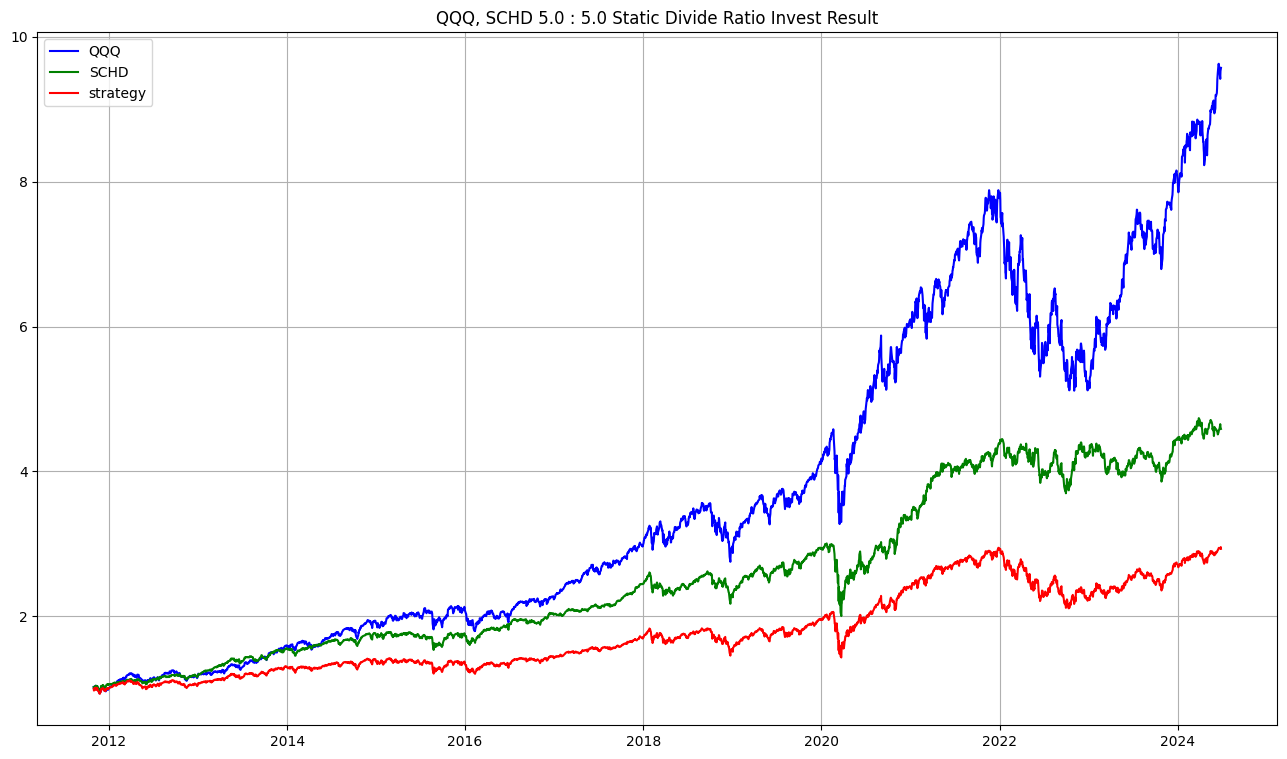

In [ ]:
plt.rcParams['figure.figsize'] = (16, 9)

plt.plot(df.index, df['주가백분율1'], color = 'blue', label = p1)
plt.plot(df.index, df['주가백분율2'], color = 'green', label = p2)
plt.plot(df.index, df['전략백분율'], color = 'red', label = "strategy")
plt.grid(True)
plt.legend(loc = 'best')

plt.title(f'{p1}, {p2} {round(p1비율 * 10, 0)} : {round((1 - p1비율) * 10, 0)} Static Divide Ratio Invest Result')

plt.show()